# Packages

In [288]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression

import statsmodels.api as sm

import contextlib
from src.preprocessing import apply_transformation

# 1. Data

## FRED dataset

In [289]:
fred_md = pd.read_csv("data/fred_md_2024_12.csv")
fred_md_short = (
    fred_md.iloc[1:]
    .assign(sasdate=pd.to_datetime(fred_md.iloc[1:].sasdate, format="%m/%d/%Y"))
    .set_index("sasdate")
)
fred_info = pd.read_csv("data/FRED_MD_updated_appendix.csv", encoding="latin1")

start_date, end_date = "1960", "2024"

for _, row in fred_info.iterrows():
    series_name = row['fred']
    transformation_code = row['tcode']

    # Apply appropriate transformation to fred df
    with contextlib.suppress(Exception):
        fred_md_short[series_name] = apply_transformation(fred_md_short[series_name], transformation_code)

fred_md_short = fred_md_short[
    (fred_md_short.index >= start_date) & (fred_md_short.index <= end_date)
].dropna(axis=1)

## Recession data

In [290]:
us_rec = pd.read_csv("data/USREC.csv")
us_rec = us_rec.assign(
    observation_date=pd.to_datetime(us_rec.observation_date)
    ).set_index("observation_date")
us_rec = us_rec.loc[fred_md_short.index,:]

## Standardization

In [291]:
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(fred_md_short), columns=fred_md_short.columns, index=fred_md_short.index)

# 2. Variable Selection

In [292]:
features_selected = ['RPI', 'CMRMTSPLx', 'UNRATE', 'USGOOD', 'AWHMAN', 'TB3SMFFM', 'CES0600000008', 'INDPRO', 'CUMFNS', 'S&P 500', 'ISRATIOx']
print("We consider the following features at time t-1: ")
for feature in features_selected:
    print(f"{feature} : {fred_info[fred_info['fred']==feature]['description'].values[0]}")

We consider the following features at time t-1: 
RPI : Real Personal Income
CMRMTSPLx : Real Manu.  and Trade Industries Sales
UNRATE : Civilian Unemployment Rate
USGOOD : All Employees:  Goods-Producing Industries
AWHMAN : Avg Weekly Hours :  Manufacturing
TB3SMFFM : 3-Month Treasury C Minus FEDFUNDS
CES0600000008 : Avg Hourly Earnings :  Goods-Producing
INDPRO : IP Index
CUMFNS : Capacity Utilization:  Manufacturing
S&P 500 : S&Ps Common Stock Price Index: Composite
ISRATIOx : Total Business:  Inventories to Sales Ratio


In [293]:
X_lagged = X_scaled.shift(1).dropna()
common_dates = X_lagged.index.intersection(us_rec.index)
X_lagged = X_lagged.loc[common_dates]
y = us_rec.loc[common_dates]

X_selected = X_lagged.loc[:,X_lagged.columns.isin(features_selected)]
X_selected_const = sm.add_constant(X_selected)

X_train, X_test, y_train, y_test = train_test_split(X_selected_const, y, test_size = 0.2, random_state=42)

In [294]:
# correlations_lagged = X_lagged.corrwith(y_aligned.squeeze())
# top_lagged_features = correlations_lagged.abs().sort_values(ascending=False).head(20)  # Show top 30

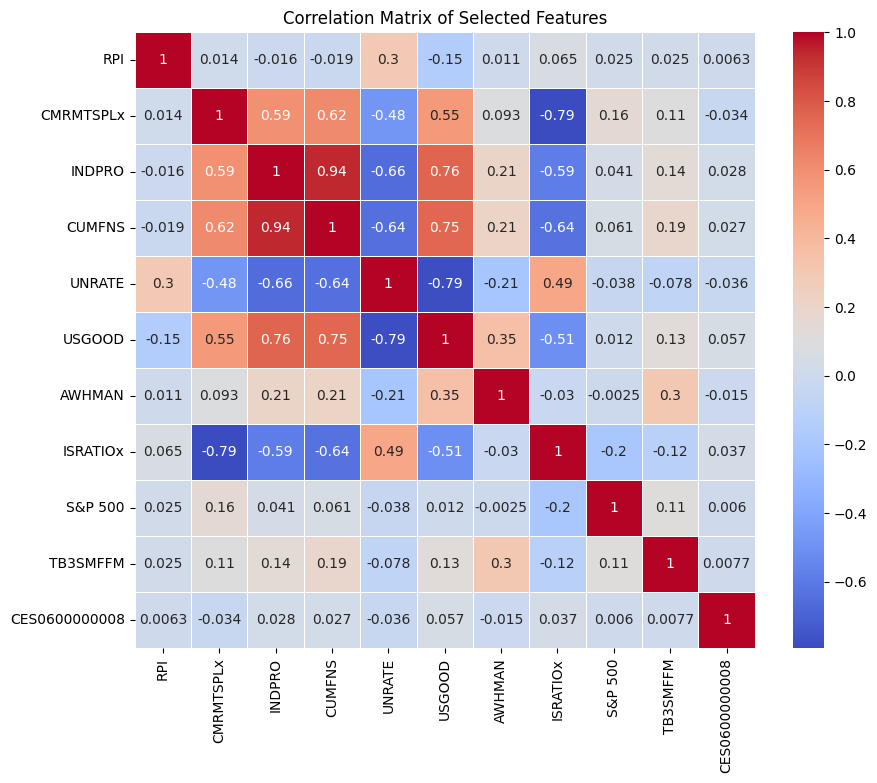

In [295]:
# Compute correlation matrix
corr_matrix = X_selected.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix of Selected Features")
plt.show()

# Logit Model

In [296]:
logit_model = sm.Logit(y_train, X_train).fit()

Optimization terminated successfully.
         Current function value: 0.192868
         Iterations 8


In [297]:
logit_model.params

const           -3.379285
RPI             -0.054189
CMRMTSPLx       -0.574269
INDPRO          -0.591646
CUMFNS          -0.238333
UNRATE          -1.396893
USGOOD          -1.290082
AWHMAN          -0.997768
ISRATIOx        -0.547134
S&P 500         -0.599728
TB3SMFFM        -0.847970
CES0600000008    0.170125
dtype: float64

## Results

In [298]:
y_pred_prob = logit_model.predict(X_test)
y_pred = (y_pred_prob >= 0.5).astype(int)
print("Logit model:\n", classification_report(y_test, y_pred))

Logit model:
               precision    recall  f1-score   support

           0       0.95      0.98      0.96       139
           1       0.73      0.53      0.62        15

    accuracy                           0.94       154
   macro avg       0.84      0.76      0.79       154
weighted avg       0.93      0.94      0.93       154



The model is missing 60 % of the recessions.

## Logit model with regularization

Ridge regularization and penalization to misclassifed recessions

In [299]:
logit_model_l2 = LogisticRegression(solver='liblinear', penalty='l1', class_weight='balanced', C=1.0, max_iter=1000)
logit_model_l2.fit(X_train, y_train.values.ravel())

LogisticRegression(class_weight='balanced', max_iter=1000, penalty='l1',
                   solver='liblinear')

In [300]:
y_pred_l2 = logit_model_l2.predict(X_test)
print("L1 Regularization:\n", classification_report(y_test, y_pred_l2))

L1 Regularization:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96       139
           1       0.59      0.87      0.70        15

    accuracy                           0.93       154
   macro avg       0.79      0.90      0.83       154
weighted avg       0.95      0.93      0.93       154

